# Librairies

In [15]:
import os
import csv
import spacy
import matplotlib.pyplot as plt
from enum import Enum
from spacy.symbols import PROPN, NOUN, CCONJ, ADP, VERB
import numpy as np

# Partie 1 : Création des dictionnaires

In [16]:
class Direct(Enum):
    NONE = 1
    START = 2
    DEST = 3

class Force(Enum):
    NONE = 1
    WEAK = 2
    STRONG = 3
    
class WordLinkSolo:
    def __init__(self, word: str, direct: Direct, force: Force):
        self.word = word
        self.direct = direct
        self.force = force

class wordLink:
    def __init__(self, word: str, fixedWord: str, direct: Direct, force: Force):
        self.word = word
        self.fixedWord = fixedWord
        self.direct = direct
        self.force = force



LINK_NOUN_STRONG = [
    WordLinkSolo("provenance",     Direct.START, Force.STRONG),
  
]
LINK_NOUN_WEAK = [
    WordLinkSolo("direction",      Direct.DEST,  Force.WEAK),
    WordLinkSolo("destination",    Direct.DEST,  Force.WEAK)
]

LINK_NOUN = LINK_NOUN_STRONG + LINK_NOUN_WEAK

LINK_ADP_FIXED_START = [
    wordLink("à","partir",       Direct.START, Force.STRONG),
    wordLink("en", "partant",    Direct.START, Force.STRONG),
    wordLink("en","passant",   Direct.START,  Force.WEAK),


]

LINK_ADP_FIXED_DEST = [
    wordLink("à","destination",  Direct.DEST,  Force.STRONG),
    wordLink("en","direction",   Direct.DEST,  Force.WEAK)
]

LINK_ADP_FIXED = LINK_ADP_FIXED_START + LINK_ADP_FIXED_DEST

LINK_ADP_START = [
    WordLinkSolo("de",     Direct.START, Force.STRONG),
    WordLinkSolo("du",     Direct.START, Force.STRONG),
    WordLinkSolo("des",    Direct.START, Force.STRONG),
    WordLinkSolo("depuis", Direct.START, Force.STRONG),


] 

LINK_ADP_DEST = [
    WordLinkSolo("à",      Direct.DEST,  Force.WEAK),
    WordLinkSolo("dans",   Direct.DEST,  Force.WEAK),
    WordLinkSolo("par",    Direct.DEST,  Force.WEAK) 
]

LINK_ADP = LINK_ADP_DEST + LINK_ADP_START

LINK_CCONJ_START = [
    WordLinkSolo("depuis",     Direct.START, Force.STRONG),
]

LINK_CCONJ_DEST = [
    WordLinkSolo("puis",       Direct.DEST,  Force.STRONG),
    WordLinkSolo("et",         Direct.DEST,  Force.STRONG),
    WordLinkSolo("enfin",      Direct.DEST,  Force.STRONG)
]


LINK_CCONJ = LINK_CCONJ_START + LINK_CCONJ_DEST

LINK_VERB_MARK_START = [
    WordLinkSolo("après",   Direct.START, Force.WEAK),
    WordLinkSolo("de",   Direct.START, Force.STRONG),
]

LINK_VERB_MARK_DEST = [
    WordLinkSolo("avant",   Direct.DEST, Force.STRONG),
]
LINK_VERB_MARK = LINK_VERB_MARK_DEST + LINK_VERB_MARK_START

LINK_VERB_START = [
    WordLinkSolo("passer",     Direct.START, Force.WEAK),
    WordLinkSolo("être",       Direct.START, Force.STRONG),
   
]

LINK_VERB_DEST = [
    WordLinkSolo("arriver",    Direct.DEST,  Force.STRONG),
    WordLinkSolo("aller",      Direct.DEST,  Force.STRONG),
    WordLinkSolo("visiter",    Direct.DEST,  Force.STRONG),
    WordLinkSolo("atterrir",   Direct.DEST,  Force.STRONG),
    WordLinkSolo("découvrir",  Direct.DEST,  Force.STRONG),
    WordLinkSolo("voyager",    Direct.DEST,  Force.STRONG),
    WordLinkSolo("rendre",     Direct.DEST,  Force.STRONG)
]

LINK_VERB = LINK_VERB_START + LINK_VERB_DEST

# Partie 2 : Logique algorithmique

In [17]:
### Paramètres:
# i : position de la locations (associé au paramètre locs)
# docs : objet résultant du traitement de la phrase par spacy
# tokens : liste des tokens associés à des locations
# locs : tableau des locations trouvées dans la phrase
# tokenToped : boolean qui indique si un token associé à la destination a déjà été trouvée
# advFor : type du mot (généré par spacy) à chercher (exemples -> VERB: verbe, DEST: destination)
### Algorithme
# Si aucun token associé à la destination n'a été trouvée alors
# Pour tous les token générés par spacy
# On regarde si il existe un token avec un type de mot égale à advFor
# Si il est égale, on vérifie si il existe déjà dans la liste des tokens
# Si il est déjà présent dans la liste des tokens on fait rien
# Si le text du token est égale à la destination passé en paramètre on l'ajoute à la liste des tokens
### Objectif
# L'objectif est de vérifier si la location passé en paramètre correspond à un token généré par spacy
# Et que le token trouvé possède un type de mot égale au paramètre advFor
# Si l'on trouve un token on renvoie vrai
def test_phrase(i, doc, tokens, locs, tokenToped, advFor, debug = False):
    if tokenToped == False:
        for token in doc:
            if token is not None:
                if advFor:
                    if token.pos == advFor:
                        isUsable = True
                        for selectedTok in tokens:
                            if type(selectedTok) != int and selectedTok == token:
                                isUsable = False
                        if isUsable:
                            if debug: print(token)
                            if token.text in locs[i]:
                                tokens[i] = token
                                return True

### Paramètres:
# docs : objet résultant du traitement de la phrase par spacy
# tokens : liste des tokens associés à des locations
# locs : tableau des locations trouvées dans la phrase
# i : position de la locations associé au paramètre locs
### Algorithme
# Pour tous les token générés par spacy par rapport à la phrase
# On regarde si le token existe dans la liste des tokens passés en paramètre
# Si il est déjà présent dans la liste des tokens on fait rien
# Si le text du token est égale à la destination passé en paramètre on l'ajoute à la liste des tokens
### Objectif
# L'objectif est de vérifier si la location passé en paramètre correspond à un token généré par spacy
# Si l'on trouve un token on renvoie vrai
def test_phrases_default(doc, tokens, locs, i):
     for token in doc:
        isUsable = True
        for tokenSelected in tokens:
            if type(tokenSelected) != int and tokenSelected == token:
                isUsable = False
        if isUsable:
            if token.text in locs[i]:
                tokens[i] = token
                return True

                    
### Paramètres:
# elem : token généré par spacy
# adp : type du mot (généré par spacy) à matcher (exemple -> VERB: verbe, DEST: destination)
# rela : Dictionnaire de référence créer dans la partie 1 avec le poids et la direction associé au mot
### Algorithme
# Si le token possède un type de mot égale à adp
# Pour chaque référence du dictionnaire
# On regarde si la lématisation du token est égale à l'une des références du dictionnaire
# Si il est égale, on arrete la boucle et on l'ajoute à fw (variable global)
### Objectif
# L'objectif est de vérifier si le token correspond à  l'une des références du dictionnaire (paramètre "rela")
# si on trouve une référence alors on l'ajout au tableau fw (variable global)
def finder(elem, adp, rela, debug = False):
    if elem.pos == adp:
        for ref in rela:
            if ref.word == elem.lemma_:
                if debug: print(f"CCONJ: {ref.word} with {ref.force.name} and {ref.direct.name}")
                fw.append(ref)
                break
                
### Paramètres:
# tokens : liste des tokens correspondants à une destination
# position : position du token
### Algorithme
# Pour tous les tokens "enfant"
# si le token enfant à pour type de text ADP alors
# pour tous les sous enfants si la dépendance est égale à "fixed" alors
# on parcours le dictionnaire de mot "LINK_ADP_FIXED"
# si on trouve une référence du dictionnaire égale au texte lématisé du sous enfant 
# alors on l'ajout à fw (variable global)
### Objectif
# L'objectif est de vérifier parmis les tokens enfant (et ses sous enfant)
# si l'un des token correspond à l'une des références du dictionnaire "LINK_ADP_FIXED"
# si on trouve une référence alors on l'ajout au tableau fw (variable global)
def LINK_ADP_FIXED_CHECK(tokens, i, debug = False):
    for child in tokens[i].children:
        if child.pos == ADP:
            for subChild in child.children:
                if subChild.dep_ == 'fixed':
                    for ref in LINK_ADP_FIXED:
                        if ref.word == child.lemma_ and ref.fixedWord == subChild.lemma_:
                            if debug: print(f"ADP_FIXED: {ref.word} {ref.fixedWord} type {ref.force.name} sens {ref.direct.name}")
                            fw.append(ref)
                            break

### Paramètres:
# tokens : liste des tokens correspondants à une destination
# position : position du token
### Algorithme
# Pour tous les tokens "enfant"
# on parcours le dictionnaire de mot "LINK_ADP"
# si on trouve une référence du dictionnaire égale au texte lématisé du sous enfant 
# alors on l'ajout à fw (variable global)
### Objectif
# L'objectif est de vérifier parmis les tokens enfant
# si l'un des token correspond à l'une des références du dictionnaire "LINK_ADP"
# si on trouve une référence alors on l'ajout au tableau fw (variable global)
def LINK_ADP_CHECK(tokens, i, debug = False):
    for child in tokens[i].children:
        for ref in LINK_ADP:
            if ref.word == child.lemma_:
                if debug: print(f"ADP: {ref.word} type {ref.force.name} sens {ref.direct.name}")
                fw.append(ref) 

### Paramètres:
# parent : token généré par spacy
### Algorithme
# Si le token à pour type de text "VERB" (est un verbe) alors
# on parcours tous ses enfants
# si le token enfant à une dépendance de type "mark" et à pour type de text "ADP" alors
# si on trouve une référence du dictionnaire "LINK_VERB_MARK" égale au texte lématisé du sous enfant 
# alors on l'ajout à fw (variable global)
### Objectif
# L'objectif est de vérifier parmis les tokens enfant
# si l'un des tokens correspond à l'une des références du dictionnaire "LINK_VERB_MARK"
# si on trouve une référence alors on l'ajout au tableau fw (variable global)
def LINK_VERB_MARK_CHECK(parent, debug = False):
     if parent.pos == VERB:
        for child in parent.children:
            if child.dep_ == 'mark' and child.pos == ADP:
                for ref in LINK_VERB_MARK:
                    if ref.word == child.lemma_:
                        if debug: print(f" VERB: {ref.word} type {ref.force.name} sens {ref.direct.name}")
                        fw.append(ref)
                        break

### Paramètres:
# parent : token généré par spacy
### Algorithme
# On parcours le dictionnaire de mot "LINK_VERB"
# si on trouve une référence du dictionnaire égale au texte lématisé du token
# alors on l'ajout à fw (variable global)
### Objectif
# L'objectif est de vérifier si le token correspond à l'une des références du dictionnaire "LINK_VERB"
# si on trouve une référence alors on l'ajout au tableau fw (variable global)
def LINK_VERB_CHECK(parent, debug = False):
    for ref in LINK_VERB:
        if ref.word == parent.lemma_:
            if debug: print(f"VERB: {ref.word} type {ref.force.name} sens {ref.direct.name}")
            fw.append(ref)
            break

### Paramètres:
# wToks : liste contenant le token et une référence d'un des dictionnaires (partie 1)
### Algorithme
# Pour tous les éléments dans wToks
# si l'un des éléments possède une direction égale à START
# après avoir modifier sa force, on ajoute le token à OrderedCities (variable global)
# puis on appelle la fonction ORDER_DEST
### Objectif
# Cherche parmis wToks quel token correspond à une valeur de départ (avec une valeur de confiance)
def ORDER_START(wToks):
    sizeForce = 0
    for i in range(len(wToks)):
        token, weight = wToks[i]
        if weight.direct == Direct.START:
            if weight.force == Force.STRONG:
                OrderedCities.insert(sizeForce, token)
                sizeForce = sizeForce + 1
            else:
                OrderedCities.append(token)
    ORDER_DEST(wToks)

### Paramètres:
# wToks : liste contenant le token et une référence d'un des dictionnaires (partie 1)
### Algorithme
# Pour tous les éléments dans wToks
# si l'un des éléments possède une direction égale à DEST
# après avoir modifier sa force, on ajoute le token à OrderedCities (variable global)
### Objectif
# Cherche parmis wToks quel token correspond à une valeur d'arrivée (avec une valeur de confiance)
def ORDER_DEST(wToks):
    sizeForce = 0
    for i in range(len(wToks)):
        token, weight = wToks[i]
        if weight.direct == Direct.DEST:
            if weight.force == Force.STRONG:
                OrderedCities.append(token)
                sizeForce = sizeForce + 1
            else:
                if sizeForce == 0:
                    OrderedCities.append(token)
                else:
                    OrderedCities.insert(len(OrderedCities)-sizeForce, token)
    
### Paramètres:
# sentence : phrase à analyser
# debug : afficher les informations pendant le calcule
### Objectif
# Trouver le point de départ et le point d'arrivée à partir d'une phrase
def analyse(sentence, debug = False):
    
    if debug: print(f"Request: {sentence}")
    # Chargement du package francais 
    nlp = spacy.load("fr_core_news_sm")
    # Traitement de la phrase par spacy -> tokenisation
    doc = nlp(sentence)
    # Initialisation du tableau contenant toute les locations
    locs = []
    
    # On cherche parmis tous les mots ceux qui sont des locations ou des entité géopolitiques
    # (c'est-à-dire pays, villes ou états) 
    for i in doc.ents:
        if i.label_ == 'LOC' or i.label_ == 'GPE': 
            locs.append(i.text)
    if debug: print(f"locs found: {locs}")

    # Si on trouve aucune location on abandonne la requête sinon on continue
    if len(locs) <= 1:
        if debug: print("Cannot parse request or invalid request.")
        return ["?","?"]
    else:
        global tokens
        # On créer un tableau vide de même longueur que le tableau des locations trouvées
        tokens = np.zeros(len(locs), dtype=object)
        # Pour chaque élément du tableau 
        for i in range(len(locs)):
            # Vrai si un token correspondant à la destionation a été trouvé, faux sinon
            tokenToped = False
            
            # On vérifie si il existe un token avec un type de mot égale à PROPN correspond à la location
            if test_phrase(i, doc, tokens, locs, tokenToped, PROPN, debug = False):
                tokenToped = True
            
            # On vérifie si il existe un token avec un type de mot égale à NOUN correspond à la location
            if test_phrase(i, doc, tokens, locs, tokenToped, NOUN, debug = False):
                tokenToped = True
            
            # On vérifie si il existe un token correspond à la location
            if tokenToped == False:
                if test_phrases_default(doc, tokens, locs, i):
                    tokenToped = True
            
            # Si aucun token correspondant à la location n'a été trouvé
            # Alors on affiche un message d'erreur
            # Et on ajoute une valeur vide
            if tokenToped == False:
                if debug: print(f"Localization {locs[i]} not found")
                tokens[i] = None
        
        # On nettoie le tableau des tokens en suppriment l'entité/item égale à None
        tmpTokens = tokens
        tokens = [] 
        for token in tmpTokens: 
            if token != None : 
                tokens.append(token)

        # On recréer un tableau vide de même longueur que le tableau des tokens liés au location
        wToks = np.zeros(len(tokens), dtype=object)
        # Pour chaque token
        for i in range(len(tokens)):
            # On affiche le text "lématiser" associé au token
            # Exemples:
            # "nous" -> "nous"
            # "sommes" -> "être"
            # "forts" -> "fort"
            if debug: print(f"Token #{i+1} : {tokens[i].lemma_}")
            global fw
            fw = []
            # On récupère le parent lié au mot
            # Exemple:
            # Pour la phrase "J'aimerais aller à paris"
            # Le token de texte "à" aura pour parent le token de texte "paris"
            parent = tokens[i].head
            
            # On récupère tous les mots associés au mot lié au token
            # Exemples:
            # Pour la phrase "J'aimerais aller à paris"
            # Le token de texte "paris" aura pour enfant le token de texts "à"
            # Le token de texte "aller" aura pour enfants les tokens de texts "J'", "aimerais", "paris"
            for child in tokens[i].children:
                finder(child,CCONJ,LINK_CCONJ, debug)
            
            # Si aucun référence vers l'un des dictionnaires n'a été trouvé
            # alors on regarde si le token parent correspond à une des rérérence du dictionnaire
            if len(fw) <= 0: 
                finder(parent,NOUN,LINK_NOUN, debug)

            # Si aucune référence vers l'un des dictionnaires n'a été trouvé
            # Alors on regarde parmis les enfants et les sous enfants si
            # l'un des tokens correspons à une référence du dictionnaire "LINK_ADP_FIXED"
            if len(fw) <= 0: 
                LINK_ADP_FIXED_CHECK(tokens, i, debug)

                
            # Si aucune référence vers l'un des dictionnaires n'a été trouvé
            # Alors on regarde parmis les enfants si
            # l'un des tokens correspons à une référence du dictionnaire "LINK_ADP"        
            if len(fw) <= 0:
                LINK_ADP_CHECK(tokens, i, debug)
            
            # Si aucune référence vers l'un des dictionnaires n'a été trouvé
            # Alors on regarde parmis les enfants si
            # l'un des tokens correspons à une référence du dictionnaire "LINK_VERB_MARK"    
            if len(fw) <= 1:
                LINK_VERB_MARK_CHECK(parent, debug)
            
            # Si aucune référence vers l'un des dictionnaires n'a été trouvé
            # Alors on regarde si le token correspons à une référence du dictionnaire "LINK_VERB"   
            if len(fw) <= 1:
                LINK_VERB_CHECK(parent, debug)
            
            # Si aucune référence vers l'un des dictionnaires n'a été trouvé
            # Alors on ajoute une valeur par défaut à fw
            if len(fw) == 0: 
                if debug: print(f"Using default weight")
                fw.append(WordLinkSolo("default", Direct.DEST,  Force.WEAK))
            
            
            # Parmis toutes les références trouvées
            # si on trouve une référence avec un force forte alors on la copie dans seletedWeight
            # sinon on ajout la première valeur de fw
            selectedWeight = None
            for j in range(len(fw)):
                if fw[j].force == Force.STRONG:
                    selectedWeight = fw[j]
                    break
            if selectedWeight is None:
                selectedWeight = fw[0]
            
            # On assigne la valeur selectedWeight avec le token dans wToks
            if debug: print(f"Using: {selectedWeight.word}")
            if debug: print("---------------")
            wToks[i] = (tokens[i], selectedWeight)
        
        # On cherche parmis les résultats quel token correspond à un point de départ
        # et quel token token correspond à un point d'arriver avec une valeur de confiance
        global OrderedCities
        OrderedCities = []
        ORDER_START(wToks)
        return OrderedCities





print(analyse("je voudrais aller à paris depuis Toulouse", True))


Request: je voudrais aller à paris depuis Toulouse
locs found: ['paris', 'Toulouse']
Token #1 : pari
ADP: à type WEAK sens DEST
VERB: aller type STRONG sens DEST
Using: aller
---------------
Token #2 : Toulouse
ADP: depuis type STRONG sens START
VERB: aller type STRONG sens DEST
Using: depuis
---------------
[Toulouse, paris]


# Partie 3 : Test du nlp

In [18]:
import pandas as pd

pd.options.display.float_format = '{:.5f}'.format

df = pd.read_csv("./dataset.csv", " ")
df.head()

/home/julien/Data/epitech/AIA-901/repo/T-AIA-901_msc2022_group-23/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,phrase,start,destination
0,Je souhaite me rendre à Brest en partant de Ch...,Chalon-sur-Saône,Brest
1,J'aimerais visiter Saint-Médard-en-Jalles en p...,Bezons,Saint-Médard-en-Jalles
2,Je souhaite aller à Saint-Martin-d'Hères en pr...,Rueil-Malmaison,Saint-Martin-d'Hères
3,Je souhaite aller vers Lyon à partir de Douai,Douai,Lyon
4,Je souhaite aller vers La Roche-sur-Yon en pro...,Cordes sur Ciel,La Roche-sur-Yon


Testing: 400/400 | Success: 216/400
 Percentage of success: 54.0%


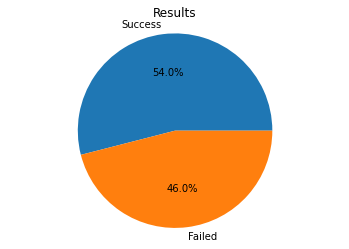


Phrase: Je souhaite aller à Saint-Martin-d'Hères en provenance de Rueil-Malmaison, Result: start -> -, destination -> Rueil, Correct answer: start -> Rueil-Malmaison, destination -> Saint-Martin-d'Hères

Phrase: Je souhaite aller vers La Roche-sur-Yon en provenance de Cordes sur Ciel, Result: start -> Cordes, destination -> Roche-sur-Yon, Correct answer: start -> Cordes sur Ciel, destination -> La Roche-sur-Yon

Phrase: Je souhaite découvrir Haguenau en provenance de Bayonne, Result: start -> ?, destination -> ?, Correct answer: start -> Bayonne, destination -> Haguenau

Phrase: J'aimerais me rendre à Le Port en passant par Palaiseau, Result: start -> Palaiseau, destination -> Port, Correct answer: start -> Palaiseau, destination -> Le Port

Phrase: J'aimerais me rendre à La Ciotat à partir de Angers, Result: start -> Angers, destination -> Ciotat, Correct answer: start -> Angers, destination -> La Ciotat

Phrase: J'aimerais aller vers Beauvais depuis Franconville, Result: start -> ?,

In [19]:
nb_success = 0
echec_phrases = []
for index, row in df.iterrows():
    phrase = row["phrase"]
    start = row["start"]
    destination = row["destination"]
    result = analyse(phrase)
    if str(result[0]).lower() == str(start).lower() and str(result[1]).lower() == str(destination).lower(): 
        nb_success += 1
    else:
        echec_phrases.append(f'Phrase: {phrase}, Result: start -> { str(result[0])}, destination -> { str(result[1])}, Correct answer: start -> {start}, destination -> {destination}')
    sys.stdout.write('\r')
    sys.stdout.write(f"Testing: {index+1}/{df.shape[0]} | Success: {nb_success}/{index+1}")
    sys.stdout.flush()
print(f"\n Percentage of success: {(nb_success * 100) / df.shape[0]}%")

total = df.shape[0]
results = [nb_success, total-nb_success]

my_labels = 'Success','Failed'
plt.pie(results,labels=my_labels,autopct='%1.1f%%')
plt.axis('equal')
plt.show()

for i in echec_phrases:
   print(f"\n{i}")
